# **Angular correlation of $\mathrm{Q}\overline{\mathrm{Q}}$ pairs produced back-to-back in a Glasma from $\mathrm{Pb}$-$\mathrm{Pb}$@$\mathrm{5.02\,\mathrm{TeV}}$**

# Version 1: toy model
Let's assume a pair is produced at the boundary, for example at $x=0$ with $y\in(0,L)$. If the direction of $\overline{\mathrm{Q}}$ is poiting outside, then the $\mathrm{Q}$ formed with random $\theta_i\in(-\pi/2,\pi/2)$ transverses the Glasma. One is interested in the angle $\Delta\theta=\theta_f-\theta_i$. 

## Default simulation parameters for the Glasma and the Wong solvers

In [1]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma for Pb-Pb at 5.02 TeV
su_group = 'su2'
A = 207     
sqrts = 5020        
ns = 50     
factor = 0.8        
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)        
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          
mu = Qs / (g**2 * factor)          	
ir = 0.1 * g**2 * mu         
uv = 10.0                     

# Wong
quark = 'charm'    
mass = 1.275      
tau_form = 1/(2*mass)*hbarc     
initialization = 'toy'         
pT = 10.0    
ntp = 10**5  
nevents = 1    
representation = 'fundamental'      
boundary = 'periodic'       

folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,   
    'NTP':  ntp,    
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
# wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll
from curraun.hqs import Angles

Using CUDA
Using SU(2)
Using double precision
Using double precision
Using double precision


## Simulation routine for evolving the Glasma & solving Wong's equations
Quark and antiquark pair initialized at the same position, with opposite momenta and random charge. Momenta $(p^x,p^y,p^z,p^\eta)$ and the ```active``` array, which keeps track of particles which reached the boundary, are stored throughout the evolution.

In [3]:
import pickle
from tqdm import tqdm

def init_mom_toy_in(pT):
    """
        Initialize all particles with the same initial transverse momentum
        but the angle is in (0, pi)
    """
    # angle = np.pi*np.random.rand(1) - np.pi/2
    angle = np.pi*np.random.rand(1)
    p0 = [0.0, pT * np.cos(angle), pT * np.sin(angle), 0.0, 0.0]

    return p0

def init_pos_in(n):

    x = np.random.rand(1) * n
    x0 = [x, 0.0, 0.0]

    return x0

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

def simulate(p, ev): 
    os.chdir(results_path)

    output = {}
    output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = init_mom_fonll(p)
        ntp = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] 
        ntp = p['NTP']

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        if initialization=='toy':
            p0 = init_mom_toy_in(pT / E0)   
        elif initialization=='fonll':
            pT = pTs_fonll[i] / E0
            p0 = init_mom_toy_in(pT / E0)
        p0s[i, :] = p0

        x0, q0 = init_pos_in(s.n), init_charge(representation)
        x0s[i, :], q0s[i, :] = x0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)
    qqbar_angle = Angles(wong_solver, ntp)

    angles = np.zeros((maxt-formt, ntp))
    pTs = np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt: 
                qqbar_angle.compute()
                angles[t-formt] = qqbar_angle.angle.copy()
                pTs[t-formt] = qqbar_angle.pT.copy() * E0

                wong_solver.evolve()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output['angles'] = angles
    tau = np.linspace(p['TFORM'], tau_sim, maxt-formt)
    output['tau'] = tau
    output['pTs'] = pTs

    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = results_path + '/' + wong_folder + '/'
    os.chdir(wong_path)

    filename = 'event_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

    os.chdir(current_path)

## Running the Wong solver over multiple Glasma events

In [4]:
# quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
# pTs = [0.5, 5.0, 10.0]
# formation_times = [0.06, 0.02]
quarks = ['charm']
quark_masses = [1.27]
pTs = [0.5, 5.0, 10.0]
formation_times = [0.06]

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = 'ang_corr_' + su_group + '_toy_pT_' + str(pT) + '_' + quarks[iq] 

        for ev in range(nevents):
            simulate(p, ev)

Charm quark
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 409/409 [00:33<00:00, 12.09it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 409/409 [00:30<00:00, 13.35it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 409/409 [00:30<00:00, 13.36it/s]


## Read data from file

In [5]:
def find_nearest(array, value):
        array = np.asarray(array)
        index = (np.abs(array - value)).argmin()
        return index

pTs_Q = [0.5, 5.0, 10.0]
taus = [0.08, 0.1, 0.3, 0.5, 1.0]

for ip, pT_Q in enumerate(pTs_Q):
    print(pT_Q)
    ang_corr_folder = 'ang_corr_' + su_group + '_toy_pT_' + str(pT_Q) + '_charm'
    ang_corr_path = results_path + ang_corr_folder
    os.chdir(ang_corr_path)

    angles, pTs = [], []
    for i, filename in enumerate(os.listdir(os.getcwd())):
        results = pickle.load(open(filename, 'rb'))
        p = results['parameters']
        ntp = p['NTP'] 
        angles.append(results['angles'])
        pTs.append(results['pTs'])
        
    angles, pTs = np.array(angles), np.array(pTs)
 
    if ip==0:
        tau = results['tau']
        indices = []
        for t in taus:
            index = find_nearest(tau, t)
            indices.append(index)

    angles_tau, pTs_tau = {}, {}
    for i, t in enumerate(taus):
        angles_tau[str(t)] = angles[:, indices[i], :].reshape(angles.shape[0]*angles.shape[2])
        pTs_tau[str(t)] = pTs[:, indices[i], :].reshape(pTs.shape[0]*pTs.shape[2])

    output = {}
    output['pT'] = pT_Q
    output['parameters'] = p
    output['taus'] = taus
    output['angles'], output['pTs'] = angles_tau, pTs_tau

    os.chdir(results_path)
    filename = ang_corr_folder + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)

0.5
5.0
10.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kde
from scipy.interpolate import interp1d


data = angles_tau[str(taus[1])]
density = kde.gaussian_kde(data)
theta = np.linspace(0,360,361)
dndtheta = density(theta)

# plt.plot(theta, dndtheta/np.max(dndtheta))
# plt.hist(data,density=True)

nbins_interp = 100
phi_low, phi_high = 100, 260
nbins = 20

n, bins, _ = plt.hist(data, bins=np.linspace(phi_low, phi_high, nbins), density=True, alpha=0.2, color='#B48EAD')  
bin_centers = 0.5*(bins[1:]+bins[:-1])

bin_interp = np.linspace(bin_centers[0], bin_centers[len(bin_centers)-1], nbins_interp)
cubic_interp = interp1d(bin_centers, n, kind='cubic')
cubic_results = cubic_interp(bin_interp)
plt.plot(bin_interp, cubic_results, color='#B48EAD', linewidth = 2.0, alpha=0.5)

## Plot results in Julia

In [19]:
using Pickle

pTs_Q = [0.5, 5.0, 10.0]

function string_as_varname(s::AbstractString,v::Any)
    s=Symbol(s)
    return @eval (($s) = ($v))
end

taus = [0.1, 0.3, 0.5, 1.0]
angles, pTs = Dict(), Dict()

for p in pTs_Q
    file = string_as_varname("file_" * string(p), "results/ang_corr_su2_toy_pT_" * string(p) * "_charm.pickle")
    data = string_as_varname("data_" * string(p), Pickle.npyload(file))
    angles[string(p)] = data["angles"]
    pTs[string(p)] = data["pTs"]
end

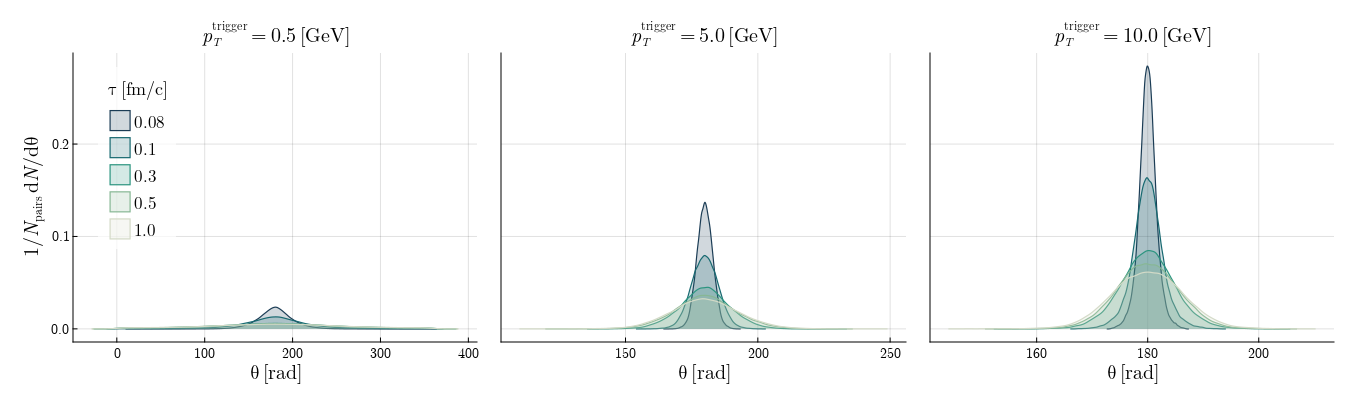

In [38]:
using CairoMakie
using ColorSchemes

taus = [0.08, 0.1, 0.3, 0.5, 1.0]

plum = cgrad(:tempo, 17, categorical = true, rev=true)
# colors = [plum[3], plum[6], plum[9], plum[12]]
colors = [plum[3], plum[6], plum[9], plum[12], plum[15]]

fig = Figure(resolution = (450*3, 400), font = "CMU Serif")

titles = [L"p_T^\mathrm{trigger}=0.5\,\mathrm{[GeV]}", L"p_T^\mathrm{trigger}=5.0\,\mathrm{[GeV]}", L"p_T^\mathrm{trigger}=10.0\,\mathrm{[GeV]}"]
axes = [Axis(fig[1,i], xlabel=L"\theta\,\mathrm{[rad]}", ylabel=L"1/N_\mathrm{pairs}\,\mathrm{d}N/\mathrm{d}\theta",
        rightspinevisible = false, topspinevisible = false, xlabelsize = 20, ylabelsize= 20, xticklabelsize=14, yticklabelsize=14,
        xtickalign = 1, xticksize=5, ytickalign=1, yticksize=5,  xlabelpadding = -5, title=titles[i], titlesize=20) for i in 1:length(pTs_Q)]

for (p, pT) in enumerate(pTs_Q) 
    for (i, tau) in enumerate(taus)
        string_as_varname("hist"*string(i),density!(axes[p], angles[string(pT)][string(tau)], color =(colors[i], 0.2), strokecolor=colors[i], strokewidth=1.2))
    end
end

# density!(ax, angles[string(pT_Q[1])]["0.1"], color =(colors[1], 0.2), strokecolor=colors[1], strokewidth=1.8)

axislegend(axes[1], [hist1, hist2, hist3, hist4, hist5], 
    [L"0.08", L"0.1", L"0.3", L"0.5", L"1.0"], L"\tau\,\mathrm{[fm/c]}",
    labelsize=17, titlesize=18, position = (0.05,0.95), orientation = :vertical, bgcolor = (:white, 0.7), framecolor = (:white, 0))

linkyaxes!(axes[1], axes[2], axes[3])
hideydecorations!(axes[2], grid = false)
hideydecorations!(axes[3], grid = false)
# δπ = 0.8
# xlims!(ax, π-δπ, π+δπ)
# δθ = 80
# xlims!(ax, 180-δθ, 180+δθ)
# ylims!(-0.001, 0.04)

display(fig)
# save("pT_spectrum_charm_vs_beauty_glasma_vs_langevin.png", fig, px_per_unit = 5.0) 

# Version 0: naive
All pairs are produced randomly in the transverse plane, when a particles reaches the boundary, its dinamycs is frozen.

## Default simulation parameters for the Glasma and the Wong solvers

In [ ]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma for Pb-Pb at 5.02 TeV
su_group = 'su3'
A = 207     
sqrts = 5020        
ns = 50     
factor = 0.8        
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)        
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          
mu = Qs / (g**2 * factor)          	
ir = 0.1 * g**2 * mu         
uv = 10.0                     

# Wong
quark = 'charm'    
mass = 1.275      
tau_form = 1/(2*mass)*hbarc     
initialization = 'toy'         
pT = 0    
ntp = 10*5  
nevents = 1    
representation = 'fundamental'      
boundary = 'frozen'       

folder = su_group + '_pT_' + str(pT) + '_' + quark       # Results folder

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,   
    'NTP':  ntp,    
    'PT': pT,          
    'FOLDER': folder,         
    }

## Set environment variables

In [ ]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll

## Simulation routine for evolving the Glasma & solving Wong's equations
Quark and antiquark pair initialized at the same position, with opposite momenta and random charge. Momenta $(p^x,p^y,p^z,p^\eta)$ and the ```active``` array, which keeps track of particles which reached the boundary, are stored throughout the evolution.

In [ ]:
import pickle
from tqdm import tqdm

current_path = os.getcwd() 
results_folder = 'results'
if not os.path.isdir(results_folder):
    os.makedirs(results_folder)
results_path = current_path + '/' + results_folder + '/'

def simulate(p, ev): 
    os.chdir(results_path)

    output = {}
    output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = init_mom_fonll(p)
        ntp = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] / E0
        ntp = p['NTP']

    # Initialize the Wong solver
    wong_solver_q = wong.WongSolver(s, ntp)
    wong_solver_aq = wong.WongSolver(s, ntp)
    x0s_q, p0s_q, q0s_q = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    x0s_aq, p0s_aq, q0s_aq = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        if initialization=='toy':
            p0_q = init_mom_toy('pT', pT / E0)            
        elif initialization=='fonll':
            pT_q = pTs_fonll[i] / E0
            p0_q = init_mom_toy('pT', pT_q / E0)
        p0_aq = [-p for p in p0_q]
        p0s_q[i, :], p0s_aq[i, :] = p0_q, p0_aq

        x0_q, q0_q = init_pos(s.n), init_charge(representation)
        x0s_q[i, :], q0s_q[i, :] = x0_q, q0_q
        x0_aq, q0_aq = x0_q, init_charge(representation)
        x0s_aq[i, :], q0s_aq[i, :] = x0_aq, q0_aq
    
    wong_solver_q.initialize(x0s_q, p0s_q, q0s_q, masses)
    wong_solver_aq.initialize(x0s_aq, p0s_aq, q0s_aq, masses)

    p_q, p_aq = np.zeros((maxt-formt, ntp, 4)), np.zeros((maxt-formt, ntp, 4))
    active_q, active_aq = np.zeros((maxt-formt, ntp)), np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                wong_solver_q.evolve()
                pmu_q = wong_solver_q.p.copy()
                p_q[t-formt] = pmu_q[:, 1:5]
                # print('p=',p_q[t-formt])
                active_q[t-formt] = wong_solver_q.active.copy()
                # print('active=', active_q[t-formt])
                indices = np.argwhere(active_q[t-formt] == 0)
                if indices.size!=0:
                    print('t=', t)
                    print('Quark')
                    print('indices=', indices)
                    print('p_indices=', p_q[t-formt][indices])

                wong_solver_aq.evolve()
                pmu_aq = wong_solver_aq.p.copy()
                p_aq[t-formt] = pmu_aq[:, 1:5]
                # print('p=',p_aq[t-formt])
                active_aq[t-formt] = wong_solver_aq.active.copy()
                # print('active=', active_aq[t-formt])
                # indices = np.where(active_aq[t-formt] == 0)[0]
                # if indices:
                #     print('t=', t)
                #     print('Antiquark')
                #     print('indices=', indices)
                #     print('p_indices=', p_aq[t-formt][indices])

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output['p_q'], output['p_aq'] = p_q, p_aq
    output['active_q'], output['active_aq'] = active_q, active_aq

    tau = np.linspace(p['TFORM'], tau_sim, maxt-formt)
    output['tau'] = tau

    wong_folder = p['FOLDER']
    if not os.path.isdir(wong_folder):
        os.makedirs(wong_folder)
    wong_path = results_path + '/' + wong_folder + '/'
    os.chdir(wong_path)

    filename = 'event_' + str(ev+1) + '.pickle'
    with open(filename, 'wb') as handle:
        pickle.dump(output, handle)
    # return output

## Running the Wong solver over multiple Glasma events

In [ ]:
# quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
# pTs = [0.5, 5.0, 10.0]
quarks = ['charm']
quark_masses = [1.27]
pTs = [10.0]
# formation_times = [0.02, 0.08]

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    p['TFORM'] = 1/(2*p['MASS'])*hbarc 
    # p['TFORM'] = formation_times[iq]

    for pT in pTs:
        print('Transverse momentum', pT, 'GeV')
        p['PT'] = pT
        tag = quarks[iq] + '_pT_' + str(pT)
        p['FOLDER'] = 'ang_corr_' + su_group + '_toy_pT_' + str(pT) + '_' + quarks[iq] 

        for ev in range(nevents):
            simulate(p, ev)